In [1]:
# import statements
import numpy as np
import xarray as xr
import glob
import random
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
import sys
import matplotlib.pyplot as plt
import PolarTestingTrainingSplit_CV
from matplotlib.colors import LinearSegmentedColormap


# Get names of models in which we are testing on
path_to_data = '/home/disk/pna2/aodhan/SurfaceTrendLearning/PoChedleyEtAl2022/TASmaps/*_TrendMaps.nc'

ModelNames = [i[70:-16] for i in glob.glob(path_to_data)]

# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

# Do CV train-test-split 
TrainingPredictorData, TrainingTargetData, TestingPredictorData, TestingTargetData, TestingTotalTrend = PolarTestingTrainingSplit_CV.training_testing_split(path_to_data)

In [2]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import OrthogonalMatchingPursuit
from scipy import stats
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm

# iterate over all CV folds (there should be eqaul number of CV folds as models)
NameValidatationPredictions = []
for model_idx in range(len(ModelNames)):
    
    # Reshape target and predictor data for model
    TrainingTargetDataShape = np.shape(TrainingTargetData[model_idx])
    TestinTargetDataShape = np.shape(TestingTargetData[model_idx])
    TrainingTargetDataReshaped = np.reshape(TrainingTargetData[model_idx], (TrainingTargetDataShape[0], TrainingTargetDataShape[1]*TrainingTargetDataShape[2]))
    TestingTargetDataReshaped = np.reshape(TestingTargetData[model_idx], (TestinTargetDataShape[0], TestinTargetDataShape[1]*TestinTargetDataShape[2]))

    # Model Design
    MLmodel = make_pipeline(StandardScaler(with_mean=False), svm.SVR(kernel='linear'))

    #MLmodel = OrthogonalMatchingPursuit()#PLSRegression(n_components=6)
    #MLmodel = SGDRegressor(penalty='l1')
    #MLmodel =  MLPRegressor(hidden_layer_sizes=(20,30,30,20))#, activation='relu', solver='adam', alpha=0.0001, learning_rate_init=0.001)
    #MLmodel = svm.SVR()
    
    # Train model
    TrainingTargetDataReshaped = TrainingTargetDataReshaped[:,0]
    pls_model = MLmodel.fit(TrainingPredictorData[model_idx], TrainingTargetDataReshaped)

    # Predict using trained model
    Y_pred = MLmodel.predict(TestingPredictorData[model_idx])

    # Apply trained model to observations
    #Y_pred_obs = MLmodel.predict(ERA5Trend1996_2014_reshaped.reshape(1, -1))
    
    # Save output for plotting
    NameValidatationPredictions.append([ModelNames[model_idx], TestingTargetDataReshaped, Y_pred])
    #ERA5_predictions.append(Y_pred_obs)

Text(0.5, 1.0, 'PLS Regression: r = 0.80')

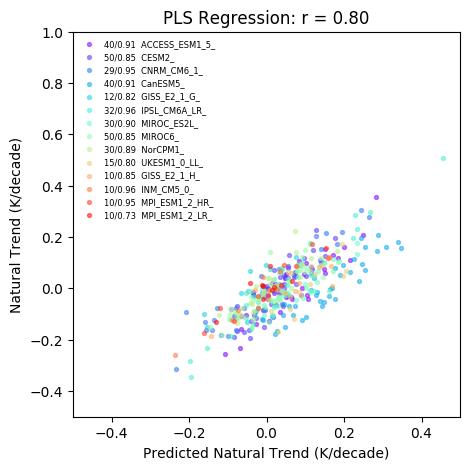

In [3]:
fig, axs_obj = plt.subplots(1, 1, figsize=(5, 5))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 14))
all_r_values = []
all_vals = []
all_preds = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]
    #ValidationData = TestingTotalTrend[model_idx]
    
    ValidationData = NameValidatationPredictions[model_idx][1][:,0]
    PredictedData = NameValidatationPredictions[model_idx][2]
    N_ensembles = len(PredictedData)
    
    r_values = []
    for predictant_idx in range(1):
        #val = ValidationData[:,predictant_idx]
        val = ValidationData
        all_vals.append(val)
        pred = PredictedData
        all_preds.append(pred)
        r = stats.pearsonr(val, pred)[0]
        r_values.append(r)
        
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)

        axs_obj.set_ylim(-0.5,1)
        axs_obj.set_xlim(-0.5,.5)
        axs_obj.set_ylabel('Natural Trend (K/decade)')
        axs_obj.set_xlabel('Predicted Natural Trend (K/decade)')
    all_r_values.append(r_values)
vals = list(np.concatenate(all_vals).flat)
preds = list(np.concatenate(all_preds).flat)
allsimulation_r = stats.pearsonr(vals, preds)[0]
axs_obj.set_title('PLS Regression: r = ' + str(allsimulation_r)[:4])


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

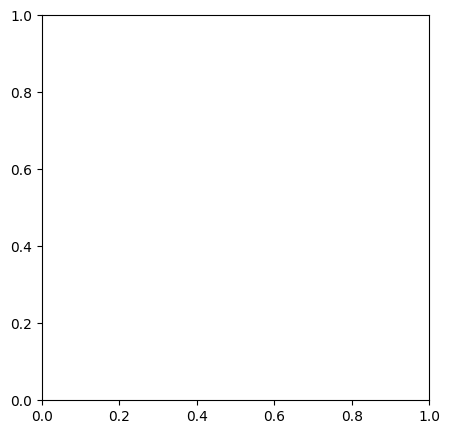

In [9]:
fig, axs_obj = plt.subplots(1, 1, figsize=(5, 5))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 20))
all_r_values = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]
    ValidationData = TestingTotalTrend[model_idx]
    #ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    N_ensembles = len(PredictedData)
    
    r_values = []
    for predictant_idx in range(1):
        #val = ValidationData[:,0]
        val = ValidationData
        pred = PredictedData[:,0] + PredictedData[:,3]
        r = stats.pearsonr(val, pred)[0]
        r_values.append(r)
        
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)

        axs_obj.set_ylim(-1,2)
        axs_obj.set_xlim(-1,2)
        axs_obj.set_ylabel('Trend (K/decade)')
        axs_obj.set_xlabel('Predicted Natural + Predicted Forced Trend (K/decade)')
    all_r_values.append(r_values)
axs_obj.set_title('PLS Regression: r = ' + str(np.nanmean(all_r_values))[:4])


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


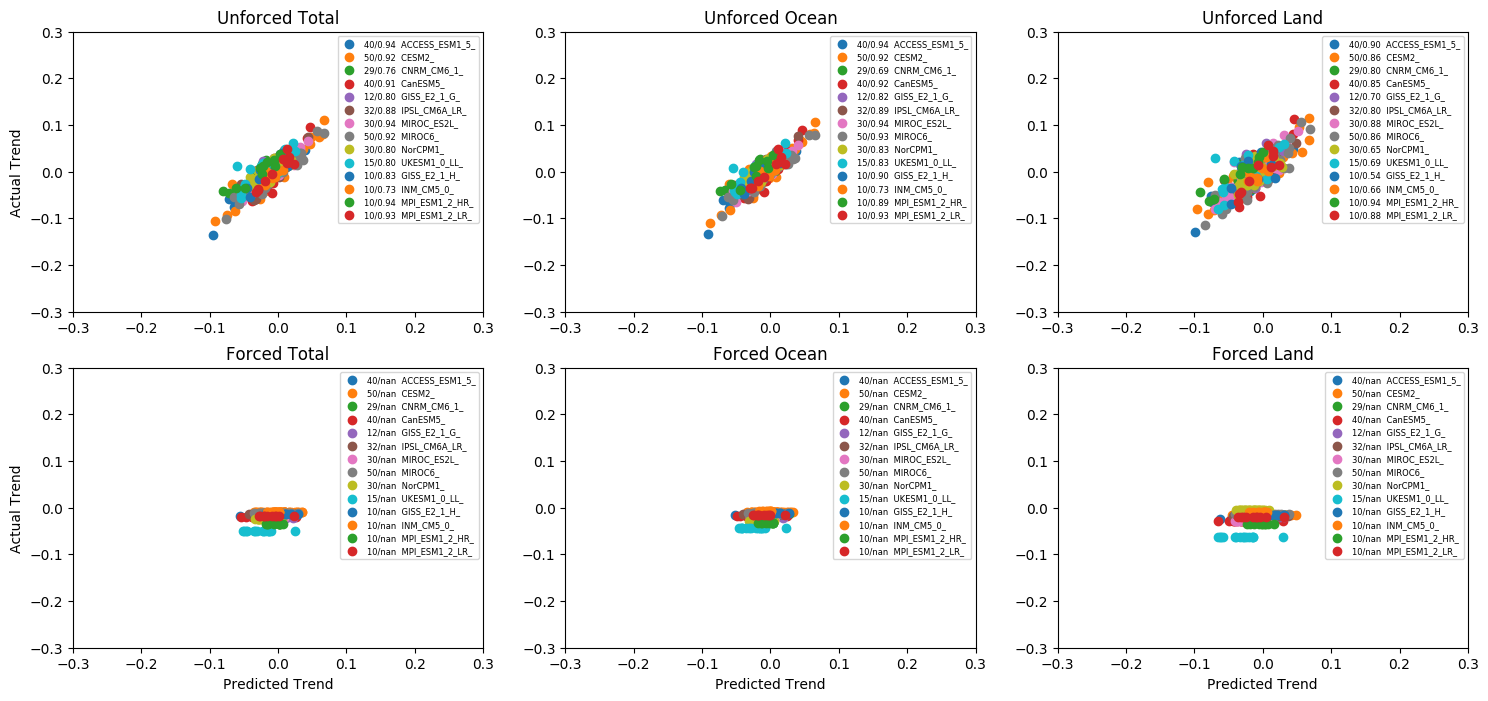

In [8]:
fig, axs = plt.subplots(2,3, figsize=(18,8))

# the second axis in ValidationData and PredictedData is stored as follows
titles = ['Unforced Total', 'Unforced Ocean', 'Unforced Land', 'Forced Total', 'Forced Ocean', 'Forced Land']

all_r_values = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    N_ensembles = len(PredictedData)

    r_values = []
    for predictant_idx in range(6):
        val = ValidationData[:,predictant_idx]
        pred = PredictedData[:,predictant_idx]
        r = stats.pearsonr(val, pred)[0]
        r_values.append(r)
        axs_obj = axs.flatten()[predictant_idx]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        axs_obj.scatter(PredictedData[:,predictant_idx], ValidationData[:,predictant_idx], label=label_id)
        axs_obj.legend(loc=1, prop={'size': 6})
        axs_obj.set_ylim(-.3,.3)
        axs_obj.set_xlim(-.3,.3)
        axs_obj.set_title(titles[predictant_idx])
        if (predictant_idx == 0) or (predictant_idx == 3):
            axs_obj.set_ylabel('Actual Trend')
        if (predictant_idx >=3):
            axs_obj.set_xlabel('Predicted Trend')
    all_r_values.append(r_values)


In [7]:
print('Natural: ', np.nanmean(ERA5_predictions, axis=0)[0,0])
print('Forced: ', np.nanmean(ERA5_predictions, axis=0)[0,3])
print('Sum: ', np.nanmean(ERA5_predictions, axis=0)[0,0] + np.nanmean(ERA5_predictions, axis=0)[0,3])

NameError: name 'ERA5_predictions' is not defined

In [20]:
# import statements
import numpy as np
import xarray as xr
import glob
import random
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep

# Set up cartopy shape file so that it can distinguish between land and ocean
land_shp_fname = shpreader.natural_earth(resolution='50m',
                                       category='physical', name='land')

land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)

def train_test_splitting(xarray_file):
    """
    Split model data into train and testing. 10 ensemble 
    members for each model are used for training as to 
    not over weight a given model. All remaining ensemble 
    members are used for testing.
    """
    # Find number of ensembles and random indicies of testing versus training ensembels
    Nensembles = len(xarray_file.ensemble_member)
    ensemble_train_indices = random.sample(range(0,Nensembles),9)

    # Select natural and forced trends as well as the training and testing data
    trend_data = xarray_file.to_array()[0]
    NatTrendsTrain = trend_data[ensemble_train_indices,0].to_numpy()
    ForTrendsTrain = trend_data[ensemble_train_indices,1].to_numpy()

    return(NatTrendsTrain, ForTrendsTrain)

def model_ensemble_reshaper(trends):
    """
    Takes a given models testing or trainging data and 
    reshapes it so that timeperiods from different ensembles
    of a given model are treated equally.
    """
    reshaped_trends = np.reshape(trends, (np.shape(trends)[0]*np.shape(trends)[1], 72,144))
    return(reshaped_trends)

def predictor_reshaper(trends):
    """
    Takes maps of trends and reshapes grid points into a vector.
    """
    PredictorVector = np.reshape(trends, (np.shape(trends)[0], np.shape(trends)[1]*np.shape(trends)[2]))
    return(PredictorVector)

def tropical_mean_trend(trends, land_sea_mask, weights, latbounds):
    """ 
    Takes map of trends and finds average over the 30S-30N region.
    """
    ocean_trends = np.array([np.ma.masked_array(data=trends[i], mask=land_sea_mask, fill_value=np.nan).filled() for i in range(len(trends))])
    land_trends = np.array([np.ma.masked_array(data=trends[i], mask=abs(land_sea_mask-1), fill_value=np.nan).filled() for i in range(len(trends))])
    length_lat_bounds = latbounds[1] - latbounds[0]
    ReshapedTrends = np.reshape(trends[:,latbounds[0]:latbounds[1],:], (np.shape(trends)[0],length_lat_bounds*144))
    #ReshapedTrends = np.reshape(trends, (np.shape(trends)[0],72*144))
    TropicalAverageTrend = np.nansum(ReshapedTrends, axis=1)/(np.nansum(weights[latbounds[0]:latbounds[1]])*144)
    TropicalOceanTrend = np.nanmean(np.reshape(ocean_trends[:,latbounds[0]:latbounds[1],:], (np.shape(ocean_trends)[0],length_lat_bounds*144)), axis=1)
    TropicalLandTrend = np.nanmean(np.reshape(land_trends[:,latbounds[0]:latbounds[1],:], (np.shape(land_trends)[0],length_lat_bounds*144)), axis=1)
    #TropicalOceanTrend = np.nanmean(np.reshape(ocean_trends, (np.shape(ocean_trends)[0],72*144)), axis=1)
    #TropicalLandTrend = np.nanmean(np.reshape(land_trends, (np.shape(land_trends)[0],72*144)), axis=1)
    
    return(TropicalAverageTrend, TropicalOceanTrend, TropicalLandTrend)

def is_land(x, y):
    """
    Uses knowledge of land points to decide whether given location 
    is land or ocean. X is longitude and Y is latitude.
    """
    return land.contains(sgeom.Point(x, y))*1

def training_testing_split(path_to_data):
    # set path to data
    ModelDataFiles = glob.glob(path_to_data)

    # select lat bounds used for subsection of globe
    latbounds = [52,72]
    # create land sea mask
    sample_grid = xr.open_dataset(ModelDataFiles[0]) 
    latitudes = sample_grid.Lat.to_numpy()
    longitudes = sample_grid.Lon.to_numpy() - 180
    land_sea_mask = []
    for x in longitudes:
        land_sea_mask_at_latitude = []
        for y in latitudes:
            land_sea_mask_at_latitude.append(is_land(x, y))
        land_sea_mask.append(land_sea_mask_at_latitude)
    land_sea_mask = np.transpose(land_sea_mask)
    land_sea_mask = np.concatenate([land_sea_mask[:,72:], land_sea_mask[:,:72]], axis=1)
    
    TrainingPredictorData = []
    TrainingTargetData = []
    TestingPredictorData = []
    TestingTargetData = []
    TestingTotalTrend = []
    for x in range(len(ModelDataFiles)):
        TrainingModelDataFiles = ModelDataFiles[:x] + ModelDataFiles[x+1:]
        TestingModelDataFiles = ModelDataFiles[x] 

        # First, take care of training data
        #########################--------Training--------#########################
        OneCVTrainingPredictorData = []
        OneCVTrainingTargetData = []
        for datafile in TrainingModelDataFiles:
            xarray_file = xr.open_dataset(datafile)
            

            # find training data for natural and forced trends
            NatTrendsTrain, ForTrendsTrain = train_test_splitting(xarray_file)

            # reshape trends so that trend maps from different time periods and ensembles are treated equal
            NatTrendsTrain = model_ensemble_reshaper(NatTrendsTrain)
            ForTrendsTrain = model_ensemble_reshaper(ForTrendsTrain)

            # weight trend maps by cosine of latitude
            weights = np.cos(np.deg2rad(latitudes)) # these will be used to weight predictors
            NatTrendsTrain_weighted = np.multiply(NatTrendsTrain, weights[np.newaxis,:,np.newaxis])
            ForTrendsTrain_weighted = np.multiply(ForTrendsTrain, weights[np.newaxis,:,np.newaxis])
            
            # true trend maps are sum of natural and forced trends
            TrueTrendsTrain = NatTrendsTrain_weighted + ForTrendsTrain_weighted
            
            # reshape predictors as vector
            TrainingTrends_vectors = predictor_reshaper(TrueTrendsTrain)

            # find tropical mean trend value
            NatTrendsTrainTropicalMean = np.transpose(tropical_mean_trend(NatTrendsTrain_weighted, land_sea_mask, weights, latbounds))
            ForTrendsTrainTropicalMean = np.transpose(tropical_mean_trend(ForTrendsTrain_weighted, land_sea_mask, weights, latbounds))

            # append to training data 
            [OneCVTrainingPredictorData.append(TrainingTrends_vectors[i]) for i in range(len(TrainingTrends_vectors))]
            [OneCVTrainingTargetData.append([NatTrendsTrainTropicalMean[i], ForTrendsTrainTropicalMean[i]]) 
            for i in range(len(ForTrendsTrainTropicalMean))]


        # Now, curate the testing data
        #########################--------Testing--------#########################

        # we only need one model of testing for this CV iteration
        test_data = xr.open_dataset(TestingModelDataFiles).to_array()[0]
        print(test_data)
        break
        # reshape trends so that trend maps from different time periods and ensembles are treated equal
        NatTrendsTest = test_data[:,0].to_numpy()
        ForTrendsTest = test_data[:,1].to_numpy()


        # reshape trends so that trend maps from different time periods and ensembles are treated equal
        print(np.shape(NatTrendsTest))
        NatTrendsTest = NatTrendsTest[:,0]#model_ensemble_reshaper(NatTrendsTest)
        ForTrendsTest = ForTrendsTest[:,0]#model_ensemble_reshaper(ForTrendsTest)

        # weight trend maps by cosine of latitude, you can use the weights from above
        NatTrendsTest_weighted = np.multiply(NatTrendsTest, weights[np.newaxis,:,np.newaxis])
        ForTrendsTest_weighted = np.multiply(ForTrendsTest, weights[np.newaxis,:,np.newaxis])

        # true trend maps are sum of natural and forced trends
        TrueTrendsTest = NatTrendsTest_weighted + ForTrendsTest_weighted
        
        # reshape predictors as vector
        OneCVTestingPredictorData = predictor_reshaper(TrueTrendsTest)
        OneCVTestingPredictorData_reshaped = np.reshape(OneCVTestingPredictorData, (np.shape(OneCVTestingPredictorData)[0],72,144))[:,latbounds[0]:latbounds[1],:]
        OneCVTestingPredictorData_reshaped = np.reshape(OneCVTestingPredictorData_reshaped, (np.shape(OneCVTestingPredictorData_reshaped)[0], (latbounds[1]-latbounds[0])*144))
        OneCVTestingPredictorDataAverageTrend = np.nansum(OneCVTestingPredictorData_reshaped, axis=1)/(np.nansum(weights[latbounds[0]:latbounds[1]])*144)

        # find tropical mean trend value
        NatTrendsTestTropicalMean = np.transpose(tropical_mean_trend(NatTrendsTest_weighted, land_sea_mask, weights, latbounds))
        ForTrendsTestTropicalMean = np.transpose(tropical_mean_trend(ForTrendsTest_weighted, land_sea_mask, weights, latbounds))

        # reshape the target variables 
        OneCVTestingTargetData= np.swapaxes([NatTrendsTestTropicalMean, ForTrendsTestTropicalMean], 0,1)

        TrainingPredictorData.append(OneCVTrainingPredictorData)
        TrainingTargetData.append(OneCVTrainingTargetData)
        TestingPredictorData.append(OneCVTestingPredictorData)
        TestingTargetData.append(OneCVTestingTargetData)
        TestingTotalTrend.append(OneCVTestingPredictorDataAverageTrend)

    return(TrainingPredictorData, TrainingTargetData, TestingPredictorData, TestingTargetData, TestingTotalTrend)
TrainingPredictorData, TrainingTargetData, TestingPredictorData, TestingTargetData, TestingTotalTrend = training_testing_split(path_to_data)

<xarray.DataArray (ensemble_member: 40, ForcedNatural: 2, TrendTimePeriod: 26, Lat: 72, Lon: 144)>
array([[[[[-6.88433349e-02, -6.88985214e-02, -6.91601261e-02, ...,
           -6.80702403e-02, -6.84518516e-02, -6.86438233e-02],
          [-2.08602205e-01, -2.06878945e-01, -2.04220757e-01, ...,
           -2.07205743e-01, -2.09156469e-01, -2.09576666e-01],
          [-3.39401960e-01, -3.45117629e-01, -3.46812516e-01, ...,
           -3.12274128e-01, -3.23006719e-01, -3.31941605e-01],
          ...,
          [-3.82686943e-01, -4.06659931e-01, -4.23772663e-01, ...,
           -2.84879565e-01, -3.15632254e-01, -3.51072401e-01],
          [-2.64532059e-01, -2.70716250e-01, -2.75776714e-01, ...,
           -2.38744453e-01, -2.47056857e-01, -2.56340742e-01],
          [-1.59836978e-01, -1.61983445e-01, -1.63144663e-01, ...,
           -1.54639199e-01, -1.57104984e-01, -1.58302829e-01]],

         [[-1.55189550e-02, -1.44475792e-02, -1.35299498e-02, ...,
           -1.78354699e-02, -1.720122